# Correlation between Internet connection and response rates
## By county

In [1]:
import json
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
states = pd.read_csv("../responseRates/Data/state_codes.csv")
counties = pd.read_csv("../responseRates/Data/county_codes.csv")

In [3]:
key = "124e1b1d5ceca3b46b3f6bd97d95ea8d4d780e28"

In [4]:
myfile = json.load(open('Data/acs_variables_2018.json'))
def search_dict(string):
    for dict in myfile['variables']:
        if string in str(myfile['variables'][dict]):
            print(dict,'\n',myfile['variables'][dict]['label'],myfile['variables'][dict]['concept'],'\n\n\n')

In [5]:
search_dict("B28002_002E")
search_dict("B28002_004E")

B28002_002E 
 Estimate!!Total!!With an Internet subscription PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD 



B28002_004E 
 Estimate!!Total!!With an Internet subscription!!Broadband of any type PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD 





In [6]:
url = f"https://api.census.gov/data/2018/acs/acs1?get=B28002_002E,B01003_001E,GEO_ID&for=county:*&key={key}"
response = requests.get(url)
if response:
    print('State: Success!')
else:
    print('State: An error has occurred.')
    sys.exit("State: "+response.text)

State: Success!


In [7]:
broadband_df = pd.DataFrame.from_records(response.json()[1:])
broadband_df.columns = response.json()[0]

broadband_df

,B28002_002E,B01003_001E,GEO_ID,state,county
0,71067,218022,0500000US01003,01,003
1,34344,114277,0500000US01015,01,015
2,24503,83442,0500000US01043,01,043
3,20646,71385,0500000US01049,01,049
4,24772,81887,0500000US01051,01,051
...,...,...,...,...,...
833,36529,133191,0500000US72113,72,113
834,78990,320967,0500000US72127,72,127
835,7870,71094,0500000US72135,72,135
836,11513,74623,0500000US72137,72,137


In [8]:
url = f"https://api.census.gov/data/2020/dec/responserate?get=RESP_DATE,GEO_ID,CRRINT&for=county:*&key={key}"
response = requests.get(url)
if response:
    print('State: Success!')
else:
    print('State: An error has occurred.')
    sys.exit("State: "+response.text)

State: Success!


In [9]:
resp_rates = pd.DataFrame.from_records(response.json()[1:])
resp_rates.columns = response.json()[0]

In [10]:
broadband_df['state_county'] = broadband_df.state + broadband_df.county
broadband_df['state_county'] = broadband_df.state_county.astype(int)
broadband_df['state'] = broadband_df.state.astype(int)
broadband_df['state_name'] = broadband_df.state.map(states.set_index('code')['state'])
broadband_df['state_short'] = broadband_df.state.map(states.set_index('code')['state_code'])
broadband_df['county_name'] = broadband_df.state_county.map(counties.set_index('code')['county'])

broadband_df["response"] = broadband_df.GEO_ID.map(resp_rates.set_index("GEO_ID")["CRRINT"])
broadband_df["response"] = broadband_df.response.astype("double")
broadband_df["internet"] = broadband_df.B28002_002E.astype("double")
broadband_df["population"] = broadband_df.B01003_001E.astype("double")
broadband_df["internetperpop"] = broadband_df.internet/broadband_df.population
broadband_df

,B28002_002E,B01003_001E,GEO_ID,state,county,state_county,state_name,state_short,county_name,response,internet,population,internetperpop
0,71067,218022,0500000US01003,1,003,1003,Alabama,AL,Baldwin,41.0,71067.0,218022.0,0.325963
1,34344,114277,0500000US01015,1,015,1015,Alabama,AL,Calhoun,40.9,34344.0,114277.0,0.300533
2,24503,83442,0500000US01043,1,043,1043,Alabama,AL,Cullman,36.5,24503.0,83442.0,0.293653
3,20646,71385,0500000US01049,1,049,1049,Alabama,AL,De Kalb,20.9,20646.0,71385.0,0.289220
4,24772,81887,0500000US01051,1,051,1051,Alabama,AL,Elmore,53.4,24772.0,81887.0,0.302514
...,...,...,...,...,...,...,...,...,...,...,...,...,...
833,36529,133191,0500000US72113,72,113,72113,Puerto Rico,PR,Ponce,10.1,36529.0,133191.0,0.274260
834,78990,320967,0500000US72127,72,127,72127,Puerto Rico,PR,San Juan,11.1,78990.0,320967.0,0.246100
835,7870,71094,0500000US72135,72,135,72135,Puerto Rico,PR,Toa Alta,10.2,7870.0,71094.0,0.110699
836,11513,74623,0500000US72137,72,137,72137,Puerto Rico,PR,Toa Baja,9.5,11513.0,74623.0,0.154282


In [11]:
def get_correlation(state=None,labels=False):
    if state != None:
        df = broadband_df[broadband_df.state_short==state]
        print("State:",df.iloc[0].state_name,f"({state})\n")
    else:
        print("All states")
        df = broadband_df
    data = df[["response","internetperpop"]]
    corr=data.corr().iloc[0,1]
    print(f"Correlation between response rates and internet connection: {round(corr,4)}")
    
    fig, ax = plt.subplots(1,1,figsize=(12,8))
    plt.scatter(df.internetperpop,df.response)
    x_range = np.arange(round(df.internetperpop.min(),2),round(df.internetperpop.max(),2)+0.01,0.01)
    plt.plot(x_range,np.poly1d(np.polyfit(df.internetperpop,df.response, 1))(x_range),c='orange')
    ax.set_xlabel("Internet per population")
    ax.set_ylabel("Response rate")
    
    if labels:
        for i in range( min(df.shape[0],200) ):
            plt.annotate(df.iloc[i].county_name, (df.iloc[i].internetperpop,df.iloc[i].response))

# All states

All states
Correlation between response rates and internet connection: 0.4746


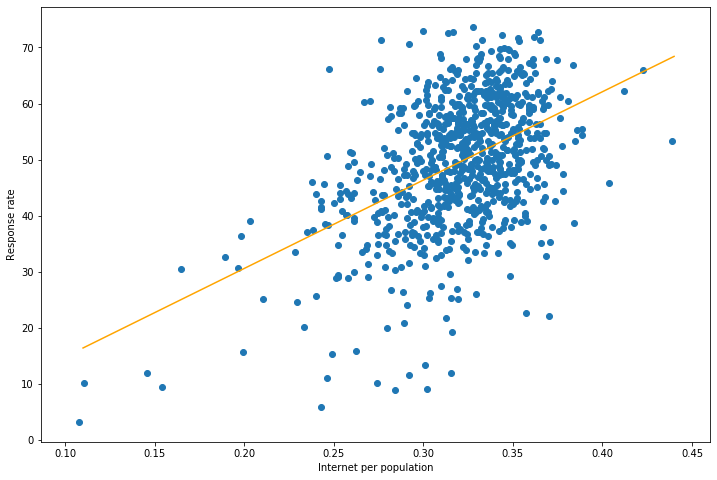

In [12]:
get_correlation()

# New York

State: New York (NY)

Correlation between response rates and internet connection: 0.1568


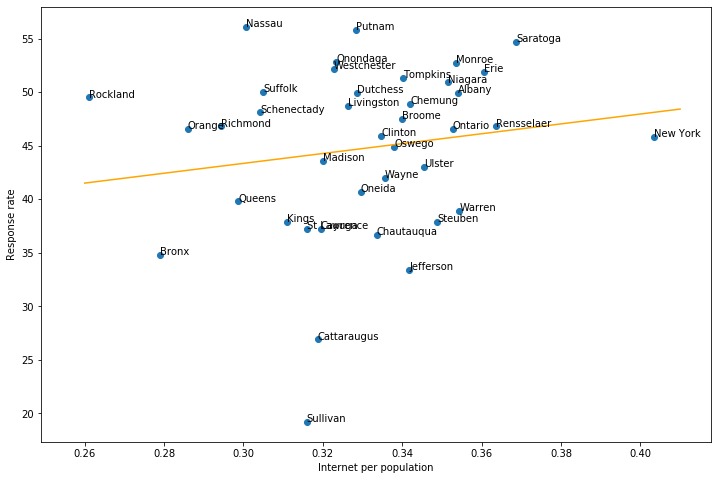

In [13]:
get_correlation("NY",True)

# Maryland

State: Maryland (MD)

Correlation between response rates and internet connection: 0.701


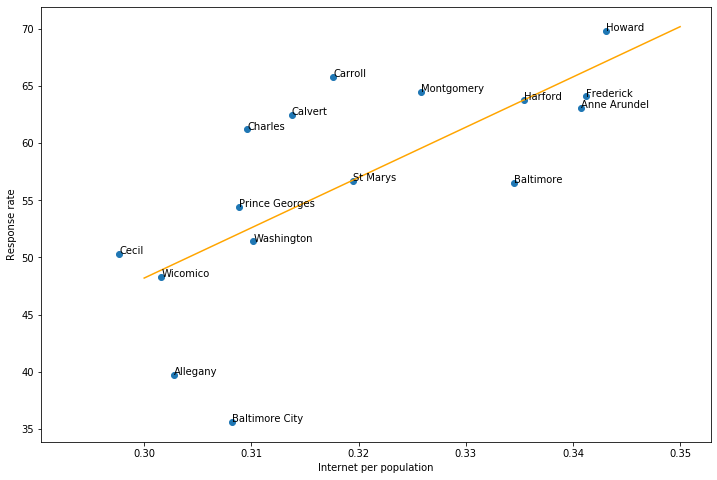

In [14]:
get_correlation("MD",True)

# New mexico

State: New Mexico (NM)

Correlation between response rates and internet connection: 0.9065


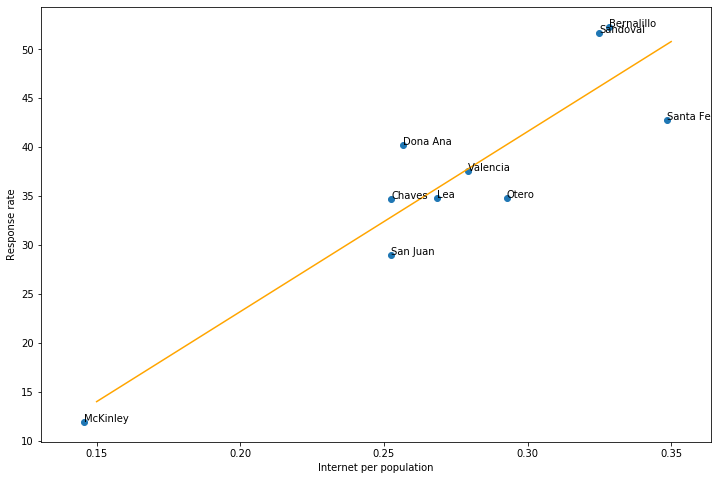

In [15]:
get_correlation("NM",True)

# Washington

State: Washington (WA)

Correlation between response rates and internet connection: 0.4385


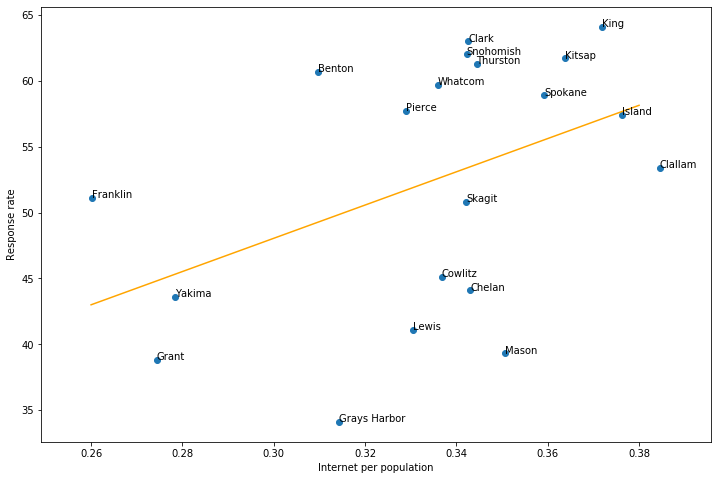

In [16]:
get_correlation("WA",True)

# Texas

State: Texas (TX)

Correlation between response rates and internet connection: 0.5843


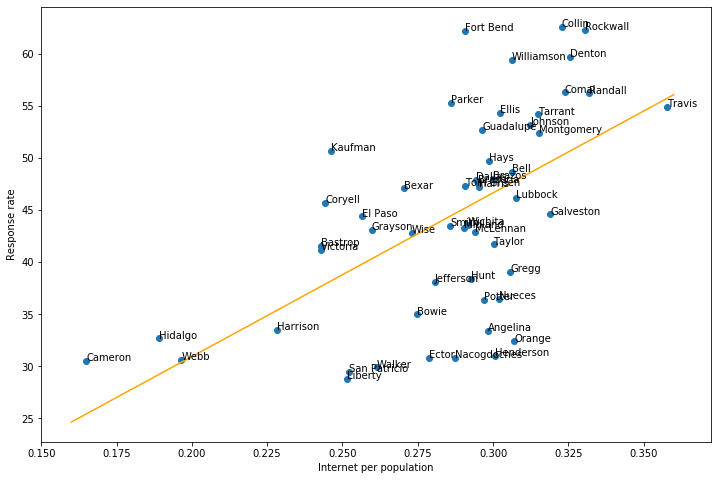

In [17]:
get_correlation("TX",True)

# Arizona

State: Arizona (AZ)

Correlation between response rates and internet connection: 0.9109


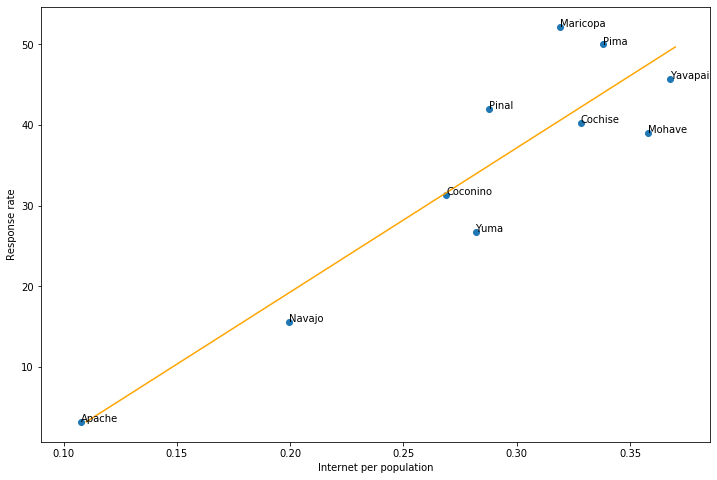

In [18]:
get_correlation("AZ",True)

In [19]:
all_states = broadband_df.state_short.unique()
correlations = []
counties_len = []
state_name = []
for s in all_states:
    df = broadband_df[broadband_df.state_short==s]
    data = df[["response","internetperpop"]]
    corr=data.corr().iloc[0,1]
    correlations.append(corr)
    counties_len.append(len(df.county.unique()))
    state_name.append(df.state_name.iloc[0])
    
df_corr = pd.DataFrame({"state":all_states, "responserates_internet_corr":correlations,
                       "counties":counties_len,"state_name":state_name})
df_corr.sort_values("responserates_internet_corr",ascending=False,inplace=True)
df_corr=df_corr[df_corr.counties>2]
df_corr[["state","state_name","responserates_internet_corr"]]

,state,state_name,responserates_internet_corr
34,ND,North Dakota,0.983257
2,AZ,Arizona,0.910861
31,NM,New Mexico,0.906483
1,AK,Alaska,0.904650
19,ME,Maine,0.890690
39,RI,Rhode Island,0.852113
24,MS,Mississippi,0.717994
20,MD,Maryland,0.701006
11,HI,Hawaii,0.690383
48,WV,West Virginia,0.686648
